# AutoML using AutoGluon

Split the data frame between training and test data. Then, train multiple ML models using AutoGluon and evaluate the performance of each model.

In [108]:
import duckdb
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
import numpy as np

df_full_merged = pd.read_parquet('full_merged.parquet')

In [30]:
from autogluon.tabular import TabularDataset, TabularPredictor
import shap
import random
import os

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Split train, calibration, and test

In [3]:
df_train = (df_full_merged
            .copy(deep=True)
            .query("Date >= '2020-01-01' and Date <= '2020-12-31'")
            .reset_index(drop=True))

In [4]:
df_calibration = (df_full_merged
        .copy(deep=True)
        .query("Date >= '2021-01-01' and Date <= '2021-06-30'")
        .reset_index(drop=True))

In [5]:
df_test = (df_full_merged
        .copy(deep=True)
        .query("Date >= '2021-07-01' and Date <= '2021-12-31'")
        .reset_index(drop=True))

Check that the report rate is similar between df_train and df_test.

In [6]:
# Calculate the percentage of each outcome in train data
outcome_rate_train = (df_train['Outcome']
                .value_counts(normalize=True)
                .mul(100)
                .round(2)
                .reset_index()
                .rename(columns={'proportion': 'Outcome Rate (%)'})
)

print("Outcome rate in training data:")
display(outcome_rate_train)

Outcome rate in training data:


,Outcome,Outcome Rate (%)
0,Dismiss,83.31
1,Report,16.69


In [7]:
# Calculate the percentage of each outcome in test data
outcome_rate_test = (df_test['Outcome']
                .value_counts(normalize=True)
                .mul(100)
                .round(2)
                .reset_index()
                .rename(columns={'proportion': 'Outcome Rate (%)'})
)

print("Outcome rate in test data:")
display(outcome_rate_test)

Outcome rate in test data:


,Outcome,Outcome Rate (%)
0,Dismiss,81.81
1,Report,18.19


# Train Models using AutoGluon

By default, AutoGluon excludes the following model types:

* Logistic Regression (see work around below)
* Simple Decision Tree
* Support Vector Machine

Remove `Date` and `AlertID` to avoid training on the columns.

In [8]:
df_train.drop(columns=['Date', 'AlertID'], inplace=True)

In [9]:
label = 'Outcome'

# Set random seed for reproducibility
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
random.seed(42)

ag_predictor = TabularPredictor(label=label,
                            problem_type='binary',
                            eval_metric='roc_auc',
                            log_to_file=True)

ag_predictor.fit(df_train)

No path specified. Models will be saved in: "AutogluonModels\ag-20241222_052126"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          20
Memory Avail:       21.02 GB / 31.75 GB (66.2%)
Disk Space Avail:   691.98 GB / 951.74 GB (72.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'       

Include logistic regression (a member of the linear model family).

In [10]:
ag_predictor.fit_extra(hyperparameters = {'LR':{'penalty':None}},
                    fit_weighted_ensemble = False)

Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: LinearModel ...
	0.6322	 = Validation score   (roc_auc)
	2.03s	 = Training   runtime
	0.01s	 = Validation runtime
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("c:\Users\chiuw\Projects\repro_SynthAML\AutogluonModels\ag-20241222_052126")


# Set Decision Threshold

A decision threshold is needed for metrics like F1, precision, and recall. Calculate the optimal threshold that maximizes the F1 score using the best model.

In [11]:
# training_threshold = (df_train['Outcome']
#                 .value_counts(normalize=True)
#                 .reset_index()
#                 .query("Outcome == 'Report'")
#                 ['proportion']
#                 .iloc[0]
#                 )

# ag_predictor.set_decision_threshold(np.round(training_threshold,3))

best_threshold = ag_predictor.calibrate_decision_threshold(df_calibration, metric='f1')

ag_predictor.set_decision_threshold(best_threshold)

Calibrating decision threshold to optimize metric f1 | Checking 51 thresholds...
Calibrating decision threshold via fine-grained search | Checking 38 thresholds...
	Base Threshold: 0.500	| val: 0.0038
	Best Threshold: 0.169	| val: 0.3671
Updating predictor.decision_threshold from 0.5 -> 0.16899999999999998
	This will impact how prediction probabilities are converted to predictions in binary classification.
	Prediction probabilities of the positive class >0.16899999999999998 will be predicted as the positive class (Report). This can significantly impact metric scores.
	You can update this value via `predictor.set_decision_threshold`.
	You can calculate an optimal decision threshold on the validation data via `predictor.calibrate_decision_threshold()`.


# Save the model

In [12]:
ag_predictor.save()

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("c:\Users\chiuw\Projects\repro_SynthAML\AutogluonModels\ag-20241222_052126")


# Show Leaderboard with Test Set

The leaderboard shows the performance of each model on the test set. Metrics include AUC, F1, precision, and recall.

The leaderboard is sorted by AUC.

In [13]:
leaderboard = ag_predictor.leaderboard(df_test, 
                                    extra_metrics=['roc_auc','f1', 'precision', 'recall']
                                    )

display(leaderboard.iloc[:, :10])

,model,score_test,roc_auc,f1,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val
0,LinearModel,0.668207,0.668207,0.393197,0.279715,0.661616,0.632196,roc_auc,0.031335,0.014402
1,LightGBM,0.667808,0.667808,0.393075,0.281752,0.649832,0.650499,roc_auc,0.004000,0.004970
2,CatBoost,0.665692,0.665692,0.391960,0.279370,0.656566,0.640820,roc_auc,0.012288,0.000000
3,WeightedEnsemble_L2,0.663254,0.663254,0.383533,0.277736,0.619529,0.664960,roc_auc,0.203998,0.063168
4,LightGBMXT,0.659634,0.659634,0.382514,0.271318,0.648148,0.633796,roc_auc,0.004451,0.000000
5,ExtraTreesEntr,0.653899,0.653899,0.358752,0.241540,0.696970,0.620097,roc_auc,0.142305,0.046442
6,NeuralNetTorch,0.653403,0.653403,0.372740,0.257198,0.676768,0.645638,roc_auc,0.035331,0.015571
7,RandomForestEntr,0.652360,0.652360,0.377011,0.259330,0.690236,0.639348,roc_auc,0.126392,0.047028
8,LightGBMLarge,0.652188,0.652188,0.367232,0.276361,0.547138,0.660851,roc_auc,0.009360,0.001503
9,XGBoost,0.648762,0.648762,0.378055,0.268604,0.638047,0.636436,roc_auc,0.017993,0.004022


Sort the leaderboard by F1 score.

In [14]:
display(leaderboard.iloc[:, :10].sort_values('f1', ascending=False))

,model,score_test,roc_auc,f1,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val
0,LinearModel,0.668207,0.668207,0.393197,0.279715,0.661616,0.632196,roc_auc,0.031335,0.014402
1,LightGBM,0.667808,0.667808,0.393075,0.281752,0.649832,0.650499,roc_auc,0.004000,0.004970
2,CatBoost,0.665692,0.665692,0.391960,0.279370,0.656566,0.640820,roc_auc,0.012288,0.000000
3,WeightedEnsemble_L2,0.663254,0.663254,0.383533,0.277736,0.619529,0.664960,roc_auc,0.203998,0.063168
4,LightGBMXT,0.659634,0.659634,0.382514,0.271318,0.648148,0.633796,roc_auc,0.004451,0.000000
9,XGBoost,0.648762,0.648762,0.378055,0.268604,0.638047,0.636436,roc_auc,0.017993,0.004022
7,RandomForestEntr,0.652360,0.652360,0.377011,0.259330,0.690236,0.639348,roc_auc,0.126392,0.047028
6,NeuralNetTorch,0.653403,0.653403,0.372740,0.257198,0.676768,0.645638,roc_auc,0.035331,0.015571
8,LightGBMLarge,0.652188,0.652188,0.367232,0.276361,0.547138,0.660851,roc_auc,0.009360,0.001503
10,RandomForestGini,0.640200,0.640200,0.364519,0.247010,0.695286,0.639712,roc_auc,0.157304,0.046095


# Check model probability predictions

Compare predicted probabilities from three models: `LinearModel`, `CatBoost`, `LightGBM`.

In [19]:
# Get prediction probabilities for both models
logit_probs = ag_predictor.predict_proba(df_test, model='LinearModel')['Report']
catboost_probs = ag_predictor.predict_proba(df_test, model='CatBoost')['Report']
lgbm_probs = ag_predictor.predict_proba(df_test, model='LightGBM')['Report']

# Create a dataframe for plotting
plot_df = pd.DataFrame({
    'Probability': np.concatenate([logit_probs, catboost_probs, lgbm_probs]),
    'Model': ['LogisticReg'] * len(logit_probs) + ['CatBoost'] * len(catboost_probs) + ['LightGBM'] * len(lgbm_probs)
})

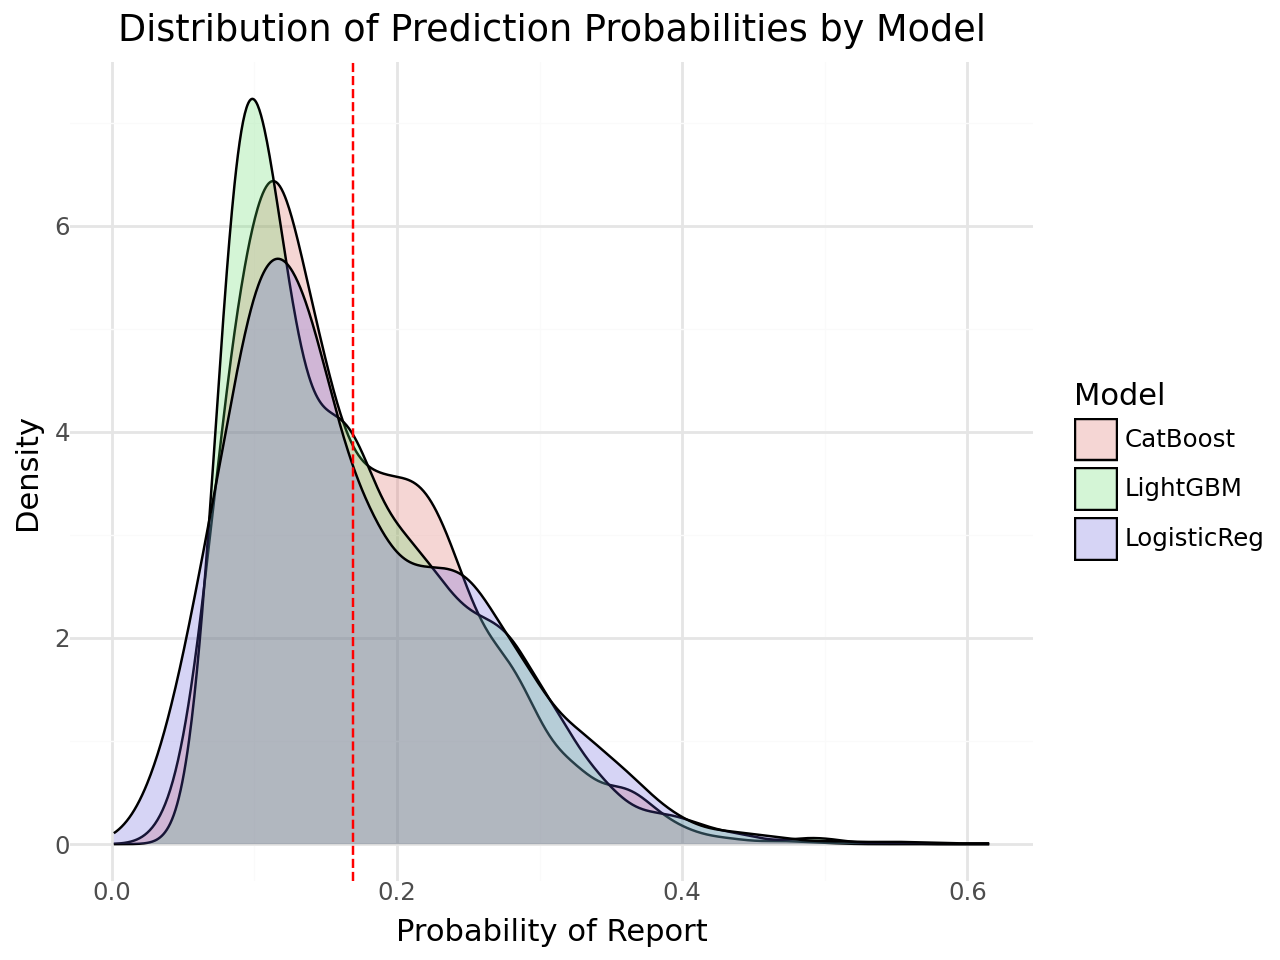

In [20]:
(p9.ggplot(plot_df, p9.aes(x='Probability', fill='Model'))
    + p9.geom_density(position='identity', alpha=0.25)
    + p9.labs(title='Distribution of Prediction Probabilities by Model',
            x='Probability of Report',
            y='Density')
    + p9.geom_vline(xintercept=best_threshold, linetype='dashed', color='red')
    + p9.theme_minimal()
)


# LightGBM: Feature Importance

Although logistic regression has the best F1 score and ROC-AUC, we will look at the feature importance of the `LightGBM` model. There are two popular methods to calculate feature importance:

1. Permutation Feature Importance: how well does each feature explain the true label?
2. SHAP Feature Importance: how sensitive are the predictions to each feature?

## Permutation Feature Importance

In [55]:
perm_feature_importance = ag_predictor.feature_importance(
        data = df_calibration,
        model = 'LightGBM',
        num_shuffle_sets=30).reset_index(names='Feature')

These features in provided data are not utilized by the predictor and will be ignored: ['AlertID', 'Date']
Computing feature importance via permutation shuffling for 56 features using 5000 rows with 30 shuffle sets...
	20.58s	= Expected runtime (0.69s per shuffle set)
	11.28s	= Actual runtime (Completed 30 of 30 shuffle sets)


In [73]:
perm_feature_importance = perm_feature_importance.sort_values(
        ['importance'], ascending=True)

# Create categorical with ordered categories based on current Feature order
perm_feature_importance['Feature'] = pd.Categorical(
        perm_feature_importance['Feature'],
        categories=perm_feature_importance['Feature'].tolist(),
        ordered=True
)

In [74]:
perm_feature_importance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, 55 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Feature     56 non-null     category
 1   importance  56 non-null     float64 
 2   stddev      56 non-null     float64 
 3   p_value     56 non-null     float64 
 4   n           56 non-null     int64   
 5   p99_high    56 non-null     float64 
 6   p99_low     56 non-null     float64 
dtypes: category(1), float64(5), int64(1)
memory usage: 5.6 KB


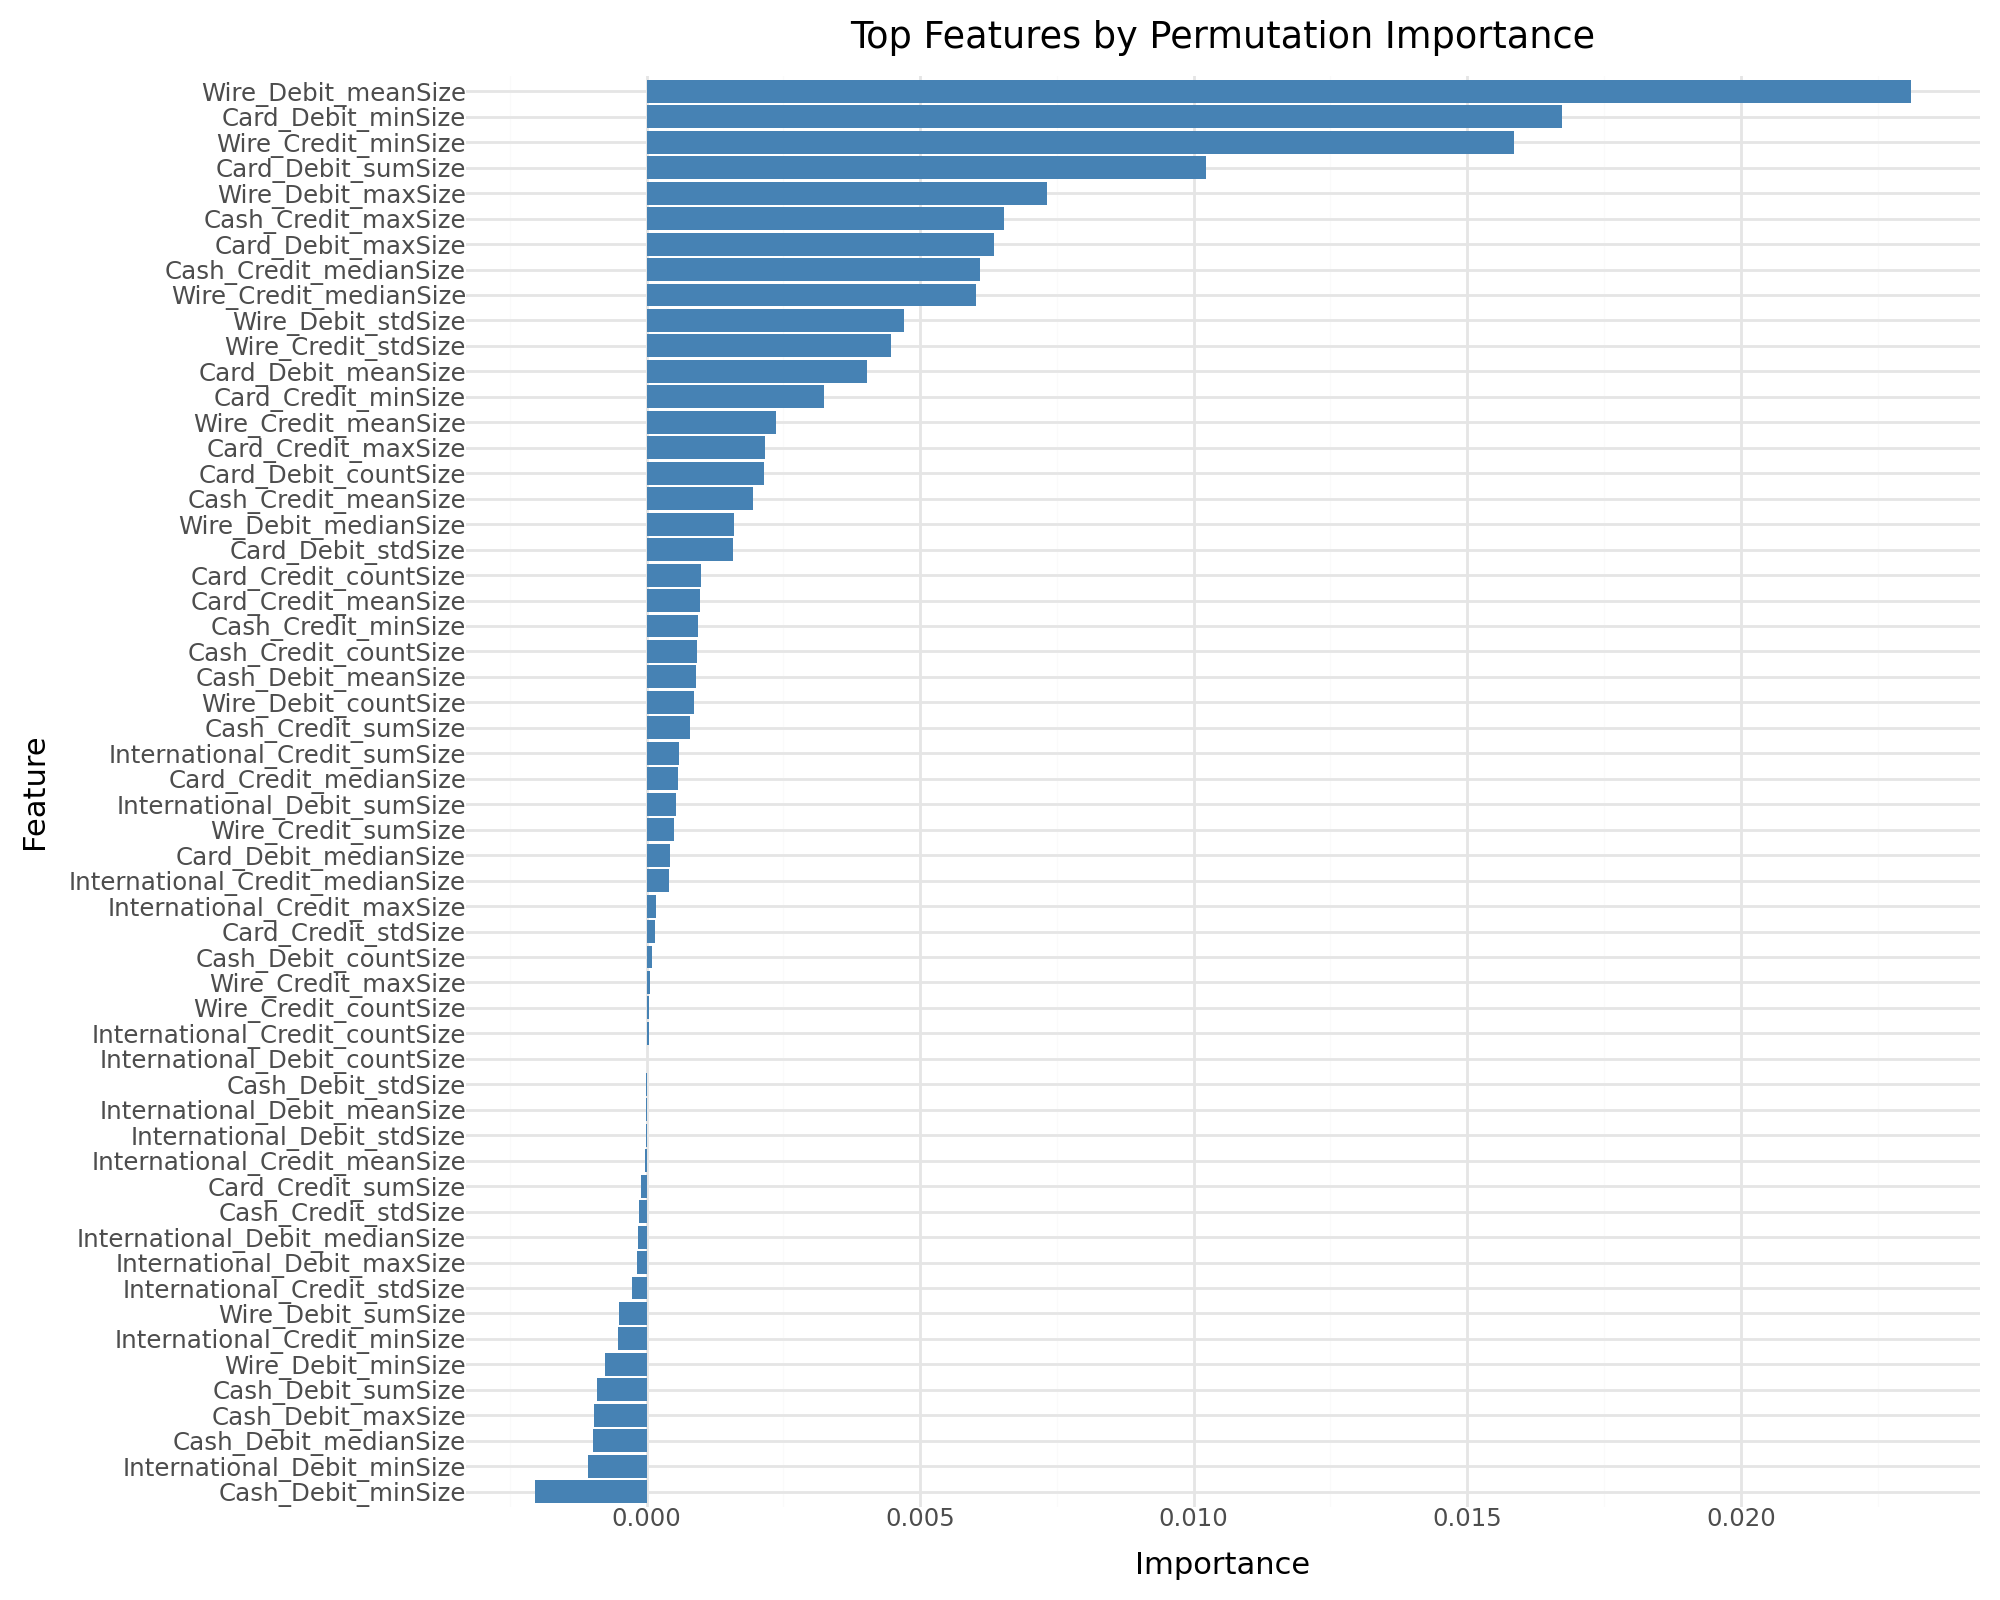

In [78]:
(p9.ggplot(perm_feature_importance, 
            p9.aes(x='Feature', y='importance'))
        + p9.geom_bar(stat='identity', fill='steelblue')
        + p9.labs(title='Top Features by Permutation Importance',
            x='Feature',
            y='Importance')
        + p9.theme_minimal()
        + p9.theme(figure_size=(10, 8))
        + p9.coord_flip()
)

## SHAP Feature Importance

In [137]:
# Create a wrapper class for shap

class AutogluonWrapper:
    def __init__(self, predictor, model_name, label, feature_names):
        self.ag_model = predictor
        self.model_name = model_name
        self.label = label
        self.feature_names = feature_names
    
    def __call__(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict_proba(X, model=self.model_name)[self.label]
    
df_train_features = df_train.copy(deep=True).drop(columns=['Outcome'])

# Create a wrapper object
ag_wrapper = AutogluonWrapper(ag_predictor, 'LightGBM', 'Report', df_train_features.columns)


In [171]:
explainer = shap.PermutationExplainer(model=ag_wrapper,
                        masker=df_train_features,
                        seed=42)

In [172]:
# Create a data set that need to be explained

feature_names = df_train_features.columns

df_calibration_features = df_calibration[feature_names]

df_calibration_features = df_calibration_features.sample(n=500, random_state=42)

In [173]:
shap_values = explainer(df_calibration_features)

PermutationExplainer explainer: 501it [00:40,  9.10it/s]                         


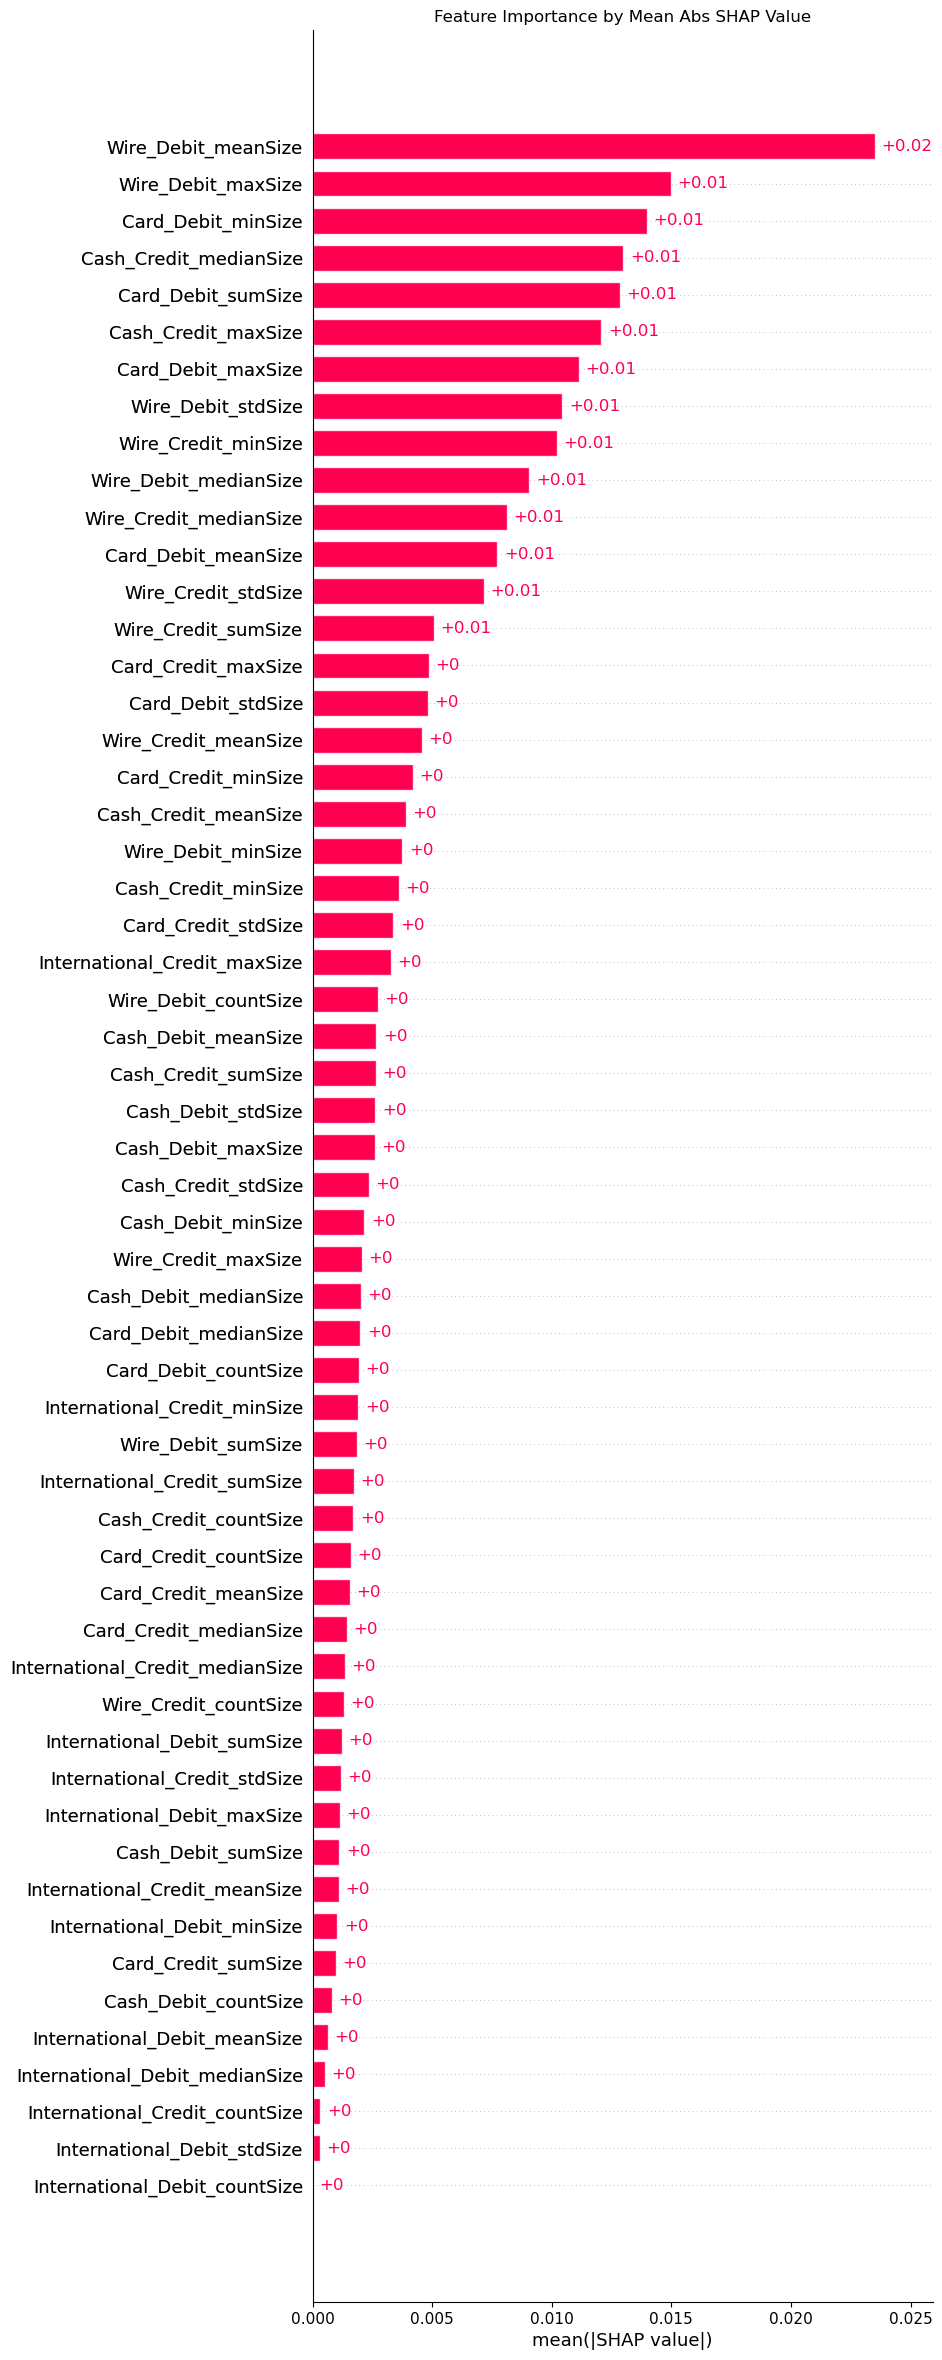

In [174]:
# Create the SHAP summary plot with title
plt.title("Feature Importance by Mean Abs SHAP Value")
shap.plots.bar(shap_values, max_display=100)
plt.clf()

# Relationships between Features and Predicted Outcome

How does `Wire_Debit_meanSize` relate to the predicted outcome? There are two popular methods to visualize the relationship between a feature and the predicted outcome:

1. Partial Dependence Plot (PDP): how does the predicted outcome change as the feature changes?
2. SHAP Scatter Plot: answers the same question as the PDP, but also shows the interaction between features.

## PDP for the top feature

<Figure size 640x480 with 0 Axes>

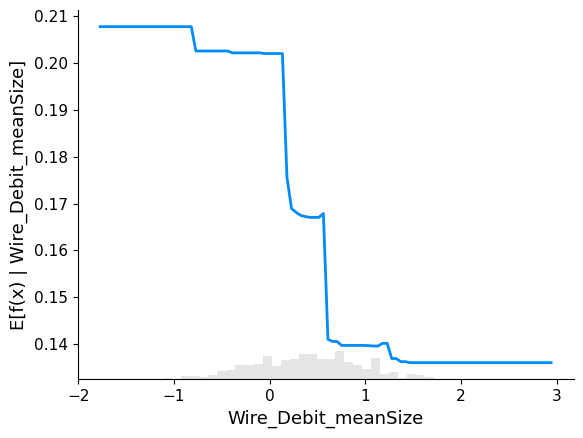

In [180]:
shap.plots.partial_dependence(
    "Wire_Debit_meanSize",  # feature to analyze
    ag_wrapper,  # model prediction function
    df_calibration_features,  # training data
    ice=False,  # whether to include individual conditional expectations
)

## SHAP Scatter Plot for the top feature

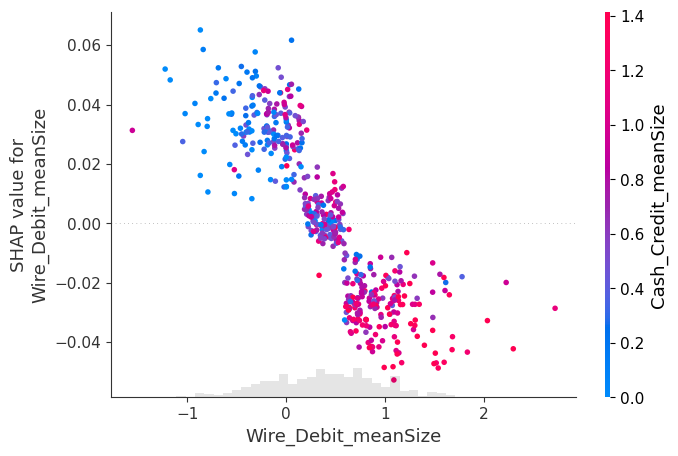

In [194]:
shap.plots.scatter(shap_values[:, "Wire_Debit_meanSize"], color=shap_values)

# Logistic Regression: Coefficients

The coefficients show how each feature impacts the probability of an alert being reported:

- Positive coefficients increase the probability of reporting
- Negative coefficients decrease the probability of reporting 
- Larger absolute values indicate stronger effects

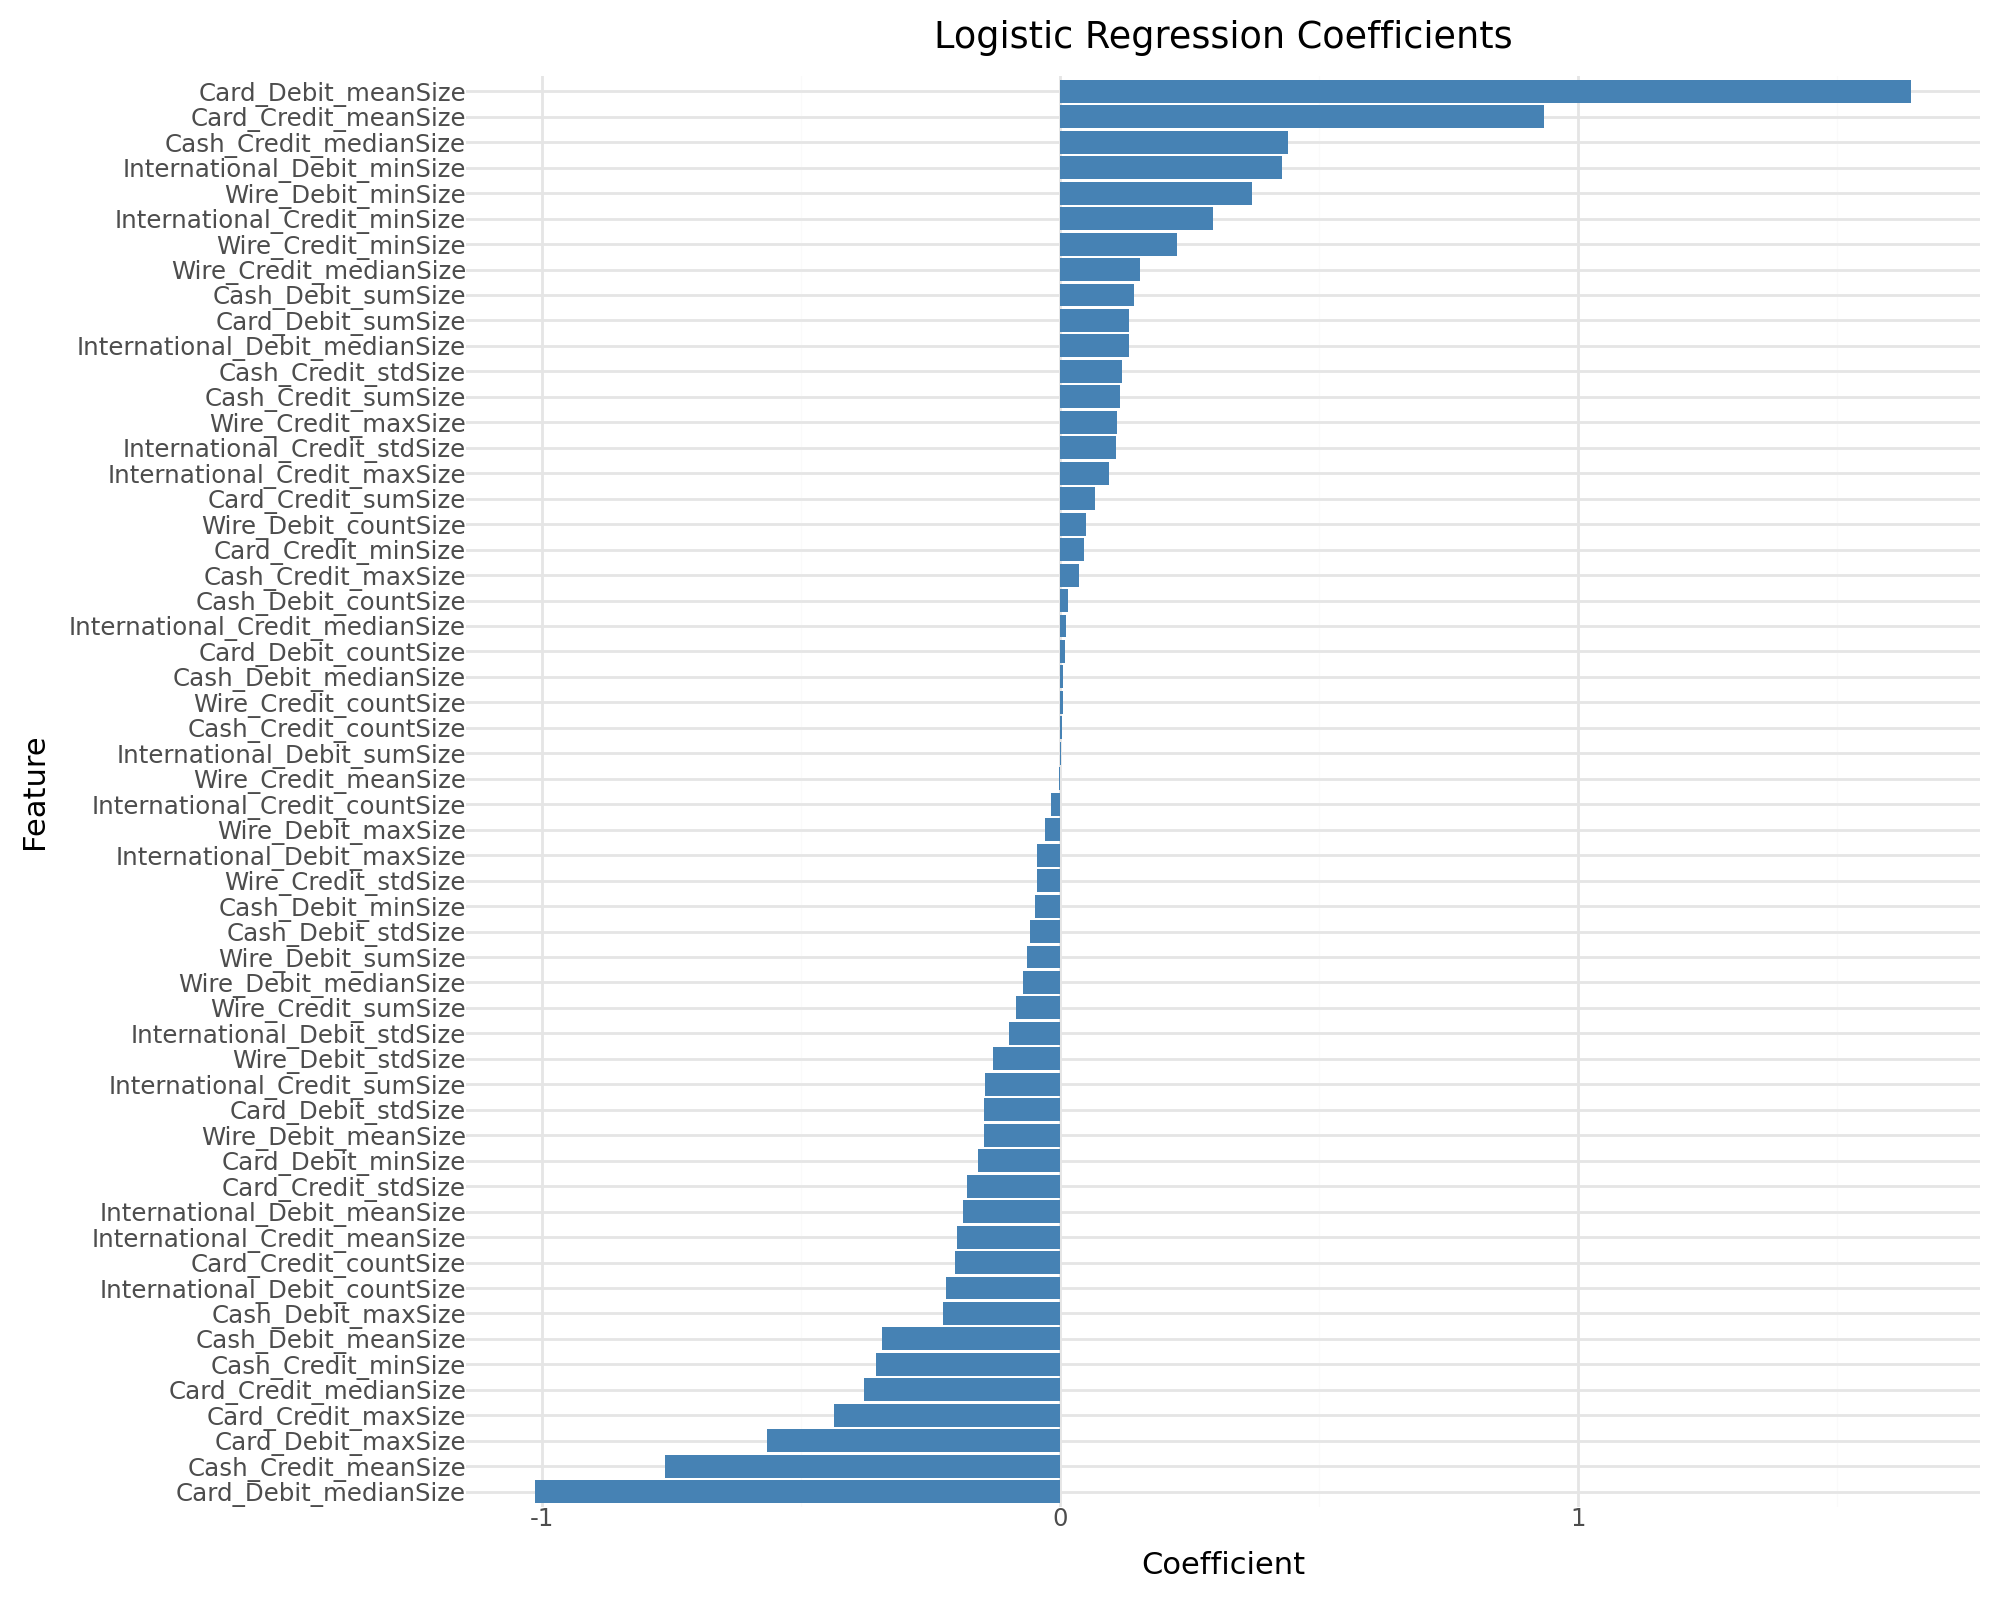

In [ ]:
# Get coefficients from logistic regression model
model_info = ag_predictor._trainer.load_model("LinearModel")

lr_model = model_info.model

coefficients = pd.DataFrame({
    'Feature': df_train_features.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=True)

# Create categorical with ordered categories based on current Feature order
coefficients['Feature'] = pd.Categorical(
    coefficients['Feature'],
    categories=coefficients['Feature'].tolist(),
    ordered=True
)

# Plot coefficients
(p9.ggplot(coefficients, p9.aes(x='Feature', y='Coefficient'))
    + p9.geom_bar(stat='identity', fill='steelblue')
    + p9.labs(title='Logistic Regression Coefficients',
            x='Feature',
            y='Coefficient')
    + p9.theme_minimal()
    + p9.theme(figure_size=(10,8))
    + p9.coord_flip()
)

# Collinear Features

Given the large number of features, there is probably high collinearity between some of the features. We will use the `PartitionExplainer` to identify collinear features (using hierarchical clustering).